Loading dataset...
Original dataset shape: (918, 12)
Missing values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Rows removed (Cholesterol = 0): 172
Remaining rows: 746
Numerical columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Setting up preprocessing pipeline...
Train set shape: (596, 11)
Test set shape: (150, 11)
Creating model pipelines...

Training and evaluating Random Forest...
Random Forest - Performance Metrics:
Accuracy: 0.8800
Precision: 0.8649
Recall: 0.8889
F1 Score: 0.8767
ROC AUC: 0.9374

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        78
           1   

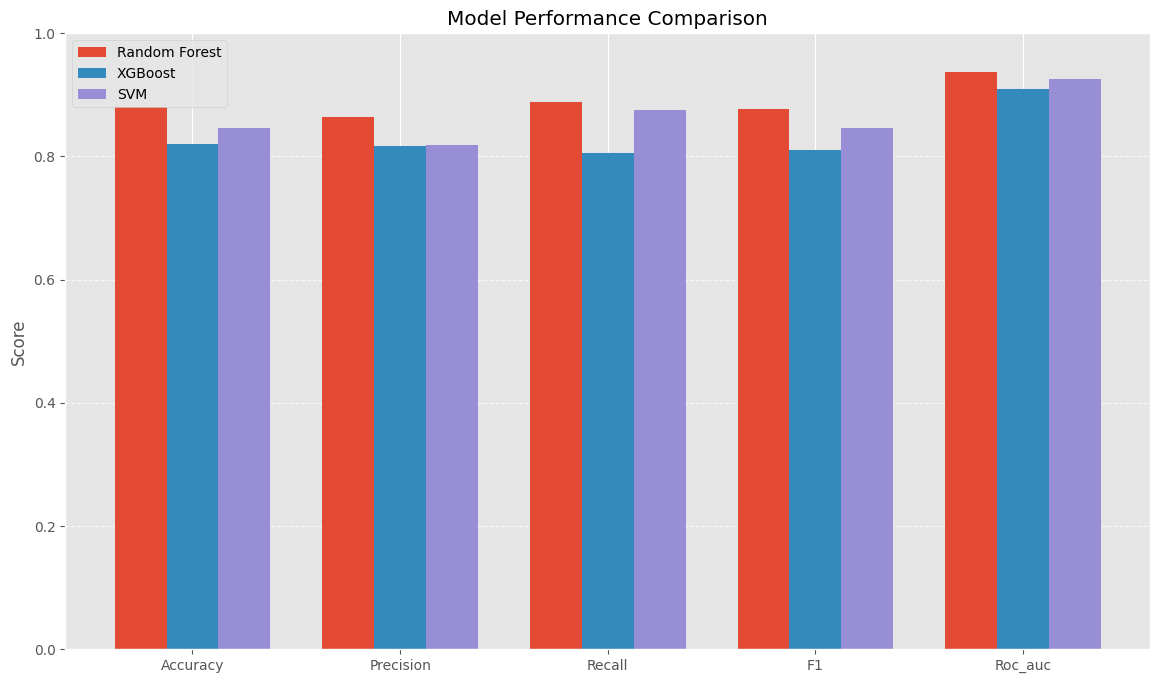


Model Performance Summary:
           Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Random Forest  0.880000   0.864865  0.888889  0.876712  0.937411
1        XGBoost  0.820000   0.816901  0.805556  0.811189  0.909722
2            SVM  0.846667   0.818182  0.875000  0.845638  0.925748


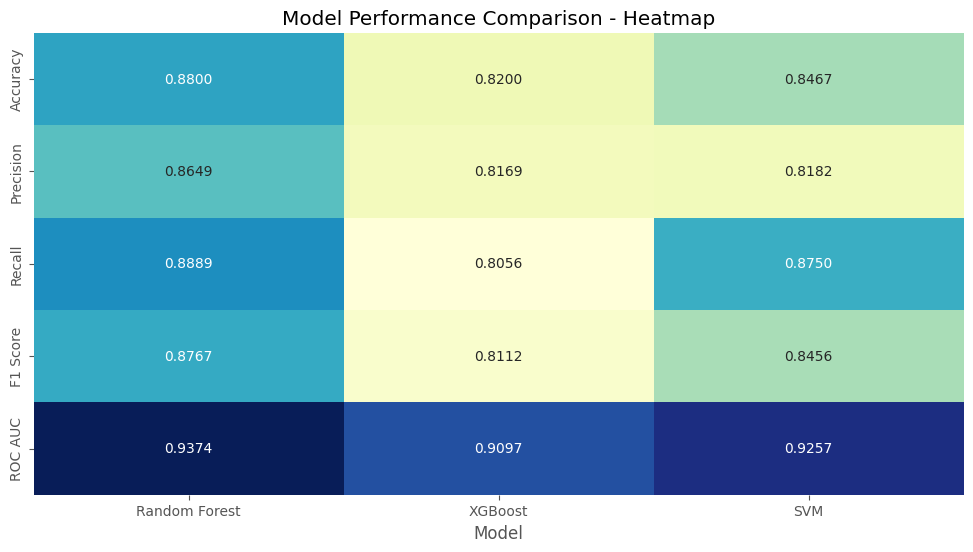

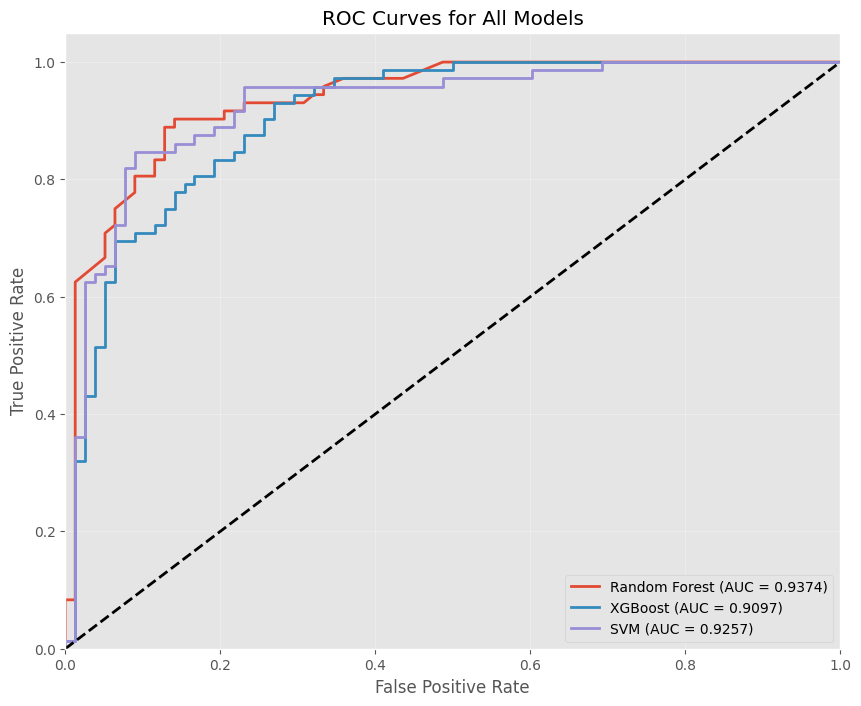

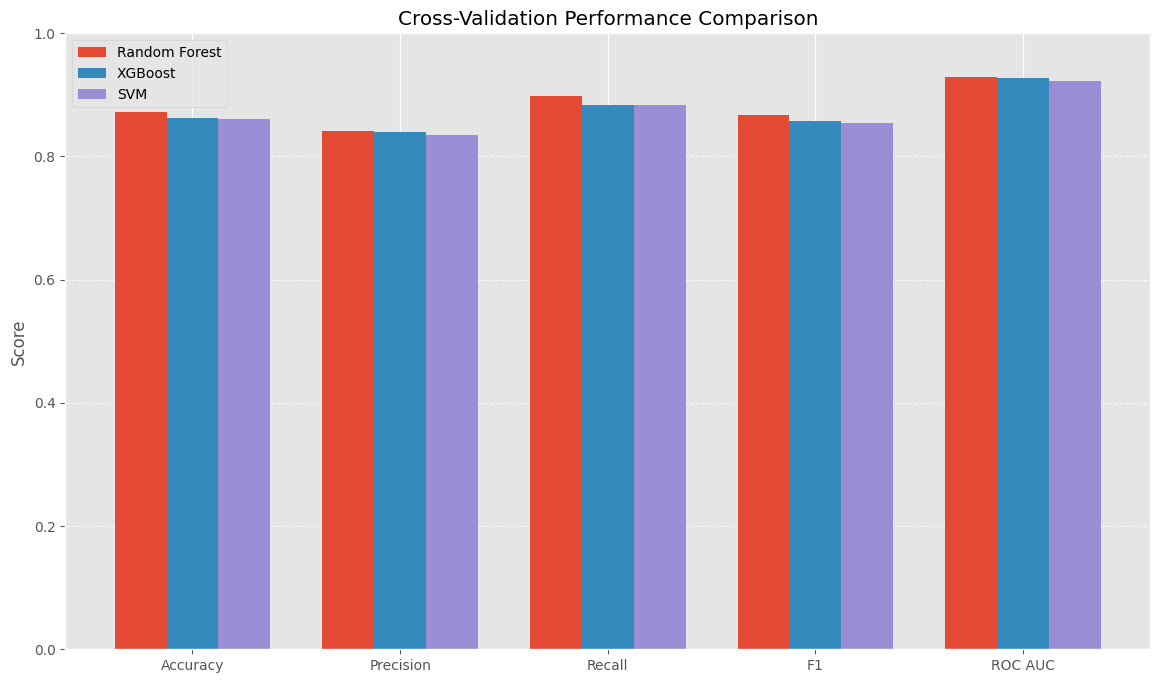


Cross-Validation Performance Summary:
           Model  CV Accuracy  CV Precision  CV Recall  CV F1 Score  \
0  Random Forest     0.872465      0.841980   0.898423     0.866897   
1        XGBoost     0.862451      0.838983   0.883557     0.857915   
2            SVM     0.860728      0.834933   0.883130     0.855039   

   CV ROC AUC  
0    0.929418  
1    0.927296  
2    0.922894  

Best performing model: Random Forest
F1 Score: 0.8767
Accuracy: 0.8800
Saving best model (Random Forest)...
Best model saved as 'best_heart_disease_model_Random Forest.pkl'

Analysis complete!


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, roc_curve, auc, roc_auc_score)
from xgboost import XGBClassifier
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Load the dataset
print("Loading dataset...")
df = pd.read_csv('heart.csv')

# Basic data exploration
print(f"Original dataset shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum()}")

# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='HeartDisease', data=df)
plt.title('Distribution of Heart Disease in Dataset')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Number of Patients')
plt.savefig('target_distribution.png')
plt.close()

# Remove rows where Cholesterol is 0
initial_rows = df.shape[0]
df = df[df['Cholesterol'] > 0]
removed_rows = initial_rows - df.shape[0]
print(f"Rows removed (Cholesterol = 0): {removed_rows}")
print(f"Remaining rows: {df.shape[0]}")

# Separate features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Create preprocessing pipeline
print("Setting up preprocessing pipeline...")
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Create model pipelines
print("Creating model pipelines...")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
])

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, kernel='rbf', C=1.0, random_state=42))
])

# Define a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\nTraining and evaluating {model_name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Print metrics
    print(f"{model_name} - Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_df = pd.DataFrame(
        conf_matrix,
        index=['Actual Negative', 'Actual Positive'],
        columns=['Predicted Negative', 'Predicted Positive']
    )
    print(f"\n{model_name} - Confusion Matrix:")
    print(conf_df)

    # Create confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.close()

    # Create ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'{model_name}_roc_curve.png')
    plt.close()

    # Cross-validation
    print(f"\nPerforming cross-validation for {model_name}...")
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_precision = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
    cv_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    cv_roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

    print(f"{model_name} - Cross-Validation Results:")
    print(f"Accuracy: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std():.4f})")
    print(f"Precision: {cv_precision.mean():.4f} (+/- {cv_precision.std():.4f})")
    print(f"Recall: {cv_recall.mean():.4f} (+/- {cv_recall.std():.4f})")
    print(f"F1: {cv_f1.mean():.4f} (+/- {cv_f1.std():.4f})")
    print(f"ROC AUC: {cv_roc_auc.mean():.4f} (+/- {cv_roc_auc.std():.4f})")

    # Return results for comparison
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_accuracy': cv_accuracy.mean(),
        'cv_precision': cv_precision.mean(),
        'cv_recall': cv_recall.mean(),
        'cv_f1': cv_f1.mean(),
        'cv_roc_auc': cv_roc_auc.mean(),
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# Evaluate all models
models = [
    (rf_pipeline, "Random Forest"),
    (xgb_pipeline, "XGBoost"),
    (svm_pipeline, "SVM")
]

results = []
for model, name in models:
    result = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results.append(result)

# Create comparison visualizations
print("\nCreating model comparison visualizations...")

# 1. Bar chart comparing model performance
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
model_names = [result['model_name'] for result in results]

plt.figure(figsize=(14, 8))
x = np.arange(len(metrics))
width = 0.25

for i, result in enumerate(results):
    values = [result[metric] for metric in metrics]
    plt.bar(x + (i - 1) * width, values, width, label=result['model_name'])

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, [m.capitalize() for m in metrics])
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('model_comparison_bar.png')
plt.show()

# 2. Create a summary table
summary_df = pd.DataFrame({
    'Model': [result['model_name'] for result in results],
    'Accuracy': [result['accuracy'] for result in results],
    'Precision': [result['precision'] for result in results],
    'Recall': [result['recall'] for result in results],
    'F1 Score': [result['f1'] for result in results],
    'ROC AUC': [result['roc_auc'] for result in results]
})

print("\nModel Performance Summary:")
print(summary_df)

# 3. Create a heatmap of the performance metrics
plt.figure(figsize=(12, 6))
sns.heatmap(summary_df.set_index('Model').T, annot=True, cmap="YlGnBu", cbar=False, fmt='.4f')
plt.title('Model Performance Comparison - Heatmap')
plt.savefig('model_comparison_heatmap.png')
plt.show()

# 4. ROC curves for all models in one plot
plt.figure(figsize=(10, 8))
for result in results:
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    plt.plot(fpr, tpr, lw=2, label=f"{result['model_name']} (AUC = {result['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('all_models_roc_curves.png')
plt.show()

# 5. Cross-validation results comparison
cv_metrics = ['cv_accuracy', 'cv_precision', 'cv_recall', 'cv_f1', 'cv_roc_auc']
cv_metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

plt.figure(figsize=(14, 8))
x = np.arange(len(cv_metrics_names))
width = 0.25

for i, result in enumerate(results):
    values = [result[metric] for metric in cv_metrics]
    plt.bar(x + (i - 1) * width, values, width, label=result['model_name'])

plt.ylabel('Score')
plt.title('Cross-Validation Performance Comparison')
plt.xticks(x, cv_metrics_names)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('cv_performance_comparison.png')
plt.show()

# 6. Create CV summary table
cv_summary_df = pd.DataFrame({
    'Model': [result['model_name'] for result in results],
    'CV Accuracy': [result['cv_accuracy'] for result in results],
    'CV Precision': [result['cv_precision'] for result in results],
    'CV Recall': [result['cv_recall'] for result in results],
    'CV F1 Score': [result['cv_f1'] for result in results],
    'CV ROC AUC': [result['cv_roc_auc'] for result in results]
})

print("\nCross-Validation Performance Summary:")
print(cv_summary_df)

# Find the best model based on F1 score
best_model_idx = np.argmax([result['f1'] for result in results])
best_model = results[best_model_idx]['model']
best_model_name = results[best_model_idx]['model_name']

print(f"\nBest performing model: {best_model_name}")
print(f"F1 Score: {results[best_model_idx]['f1']:.4f}")
print(f"Accuracy: {results[best_model_idx]['accuracy']:.4f}")
